In [6]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt 
import optax
from optax.schedules import warmup_cosine_decay_schedule

from src.utils import from_timeseries_to_dataset
from src.kernel import TSGaussGaussKernel,VFTSGaussKernel,GaussKernel,VFSGaussKernel,VFTSCauchyKernel
from src.lddmm import varifold_registration, DeformationGradient,Shooting,Flowing

In [2]:
def plot2Dfigure(s_sig,t_sig,p0,shoot,flow,mask_s_sig=None,mask_t_sig=None,p1=None,nv=50,nh=50): 
    if mask_s_sig is None:
        s_sig = (s_sig,)
        plot_s_sig = s_sig 
    else: 
        plot_s_sig = s_sig[np.where(mask_s_sig==True)[0],:]
        s_sig = (s_sig,mask_s_sig)
  
    if mask_t_sig is None: 
        t_sig = (t_sig,)
        plot_t_sig = t_sig
    else: 
        plot_t_sig = t_sig[np.where(mask_t_sig==True)[0],:]
        t_sig = (t_sig,mask_t_sig)
    
    if p1 is None: 
        p = (p0,)
    else: 
        p = (p0,p1)

    p_sig = shoot(*p,*s_sig)[-1]
    if mask_s_sig is None: 
        plot_p_sig = p_sig
    else: 
        plot_p_sig = p_sig[np.where(mask_s_sig==True)[0],:]

    fig,axs = plt.subplots(2,1,sharex=True,sharey=True, figsize = (10,5))
    axs[0].plot(*plot_s_sig.T, label = "from")
    axs[0].legend()
    axs[1].plot(*plot_t_sig.T, color = "green", label = "to")
    axs[1].plot(*plot_p_sig.T, color = "r", label = "warping")
    axs[1].legend()
    sz = 0.2 
    a = min(np.min(plot_s_sig[:,0]),np.min(plot_t_sig[:,0]),np.min(plot_p_sig[:,0]))
    b = max(np.max(plot_s_sig[:,0]),np.max(plot_t_sig[:,0]),np.max(plot_p_sig[:,0]))
    c = min(np.min(plot_s_sig[:,1]),np.min(plot_t_sig[:,1]),np.min(plot_p_sig[:,1]))
    d = max(np.max(plot_s_sig[:,1]),np.max(plot_t_sig[:,1]),np.max(plot_p_sig[:,1]))
    lsp1 = np.linspace(a-sz*(b-a),b+sz*(b-a),nv,dtype=np.float32)
    lsp2 = np.linspace(c-sz*(d-c),d+sz*(d-c),nh,dtype=np.float32)
    X1, X2 = np.meshgrid(lsp1,lsp2)
    axs[0].plot(X1,X2,'k',linewidth=.25)
    axs[0].plot(X1.T,X2.T,'k',linewidth=.25)
    x = np.concatenate((X1.reshape(nv*nh,1),X2.reshape(nv*nh,1)),axis=1)
    phix = flow(x,*p,*s_sig)[0]
    X1 = phix[:,0].reshape(nh,nv)
    X2 = phix[:,1].reshape(nh,nv)
    axs[1].plot(X1,X2,'k',linewidth=.25)
    axs[1].plot(X1.T,X2.T,'k',linewidth=.25)
    return fig,axs

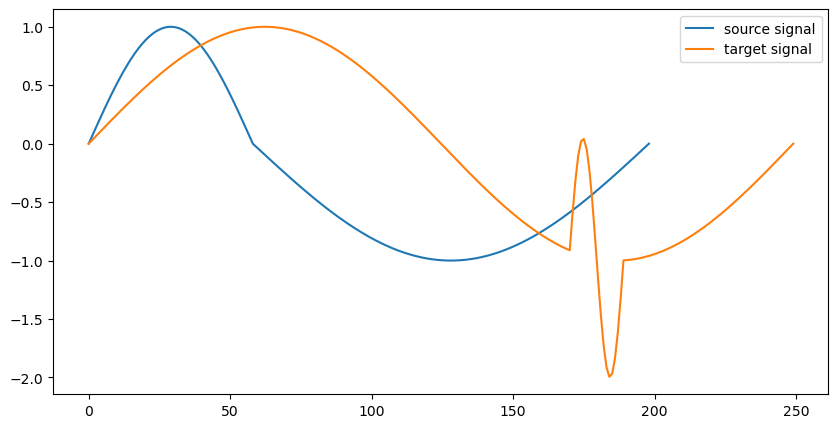

In [3]:
t_sig = np.sin(np.linspace(0,1,250)*2*np.pi)
t_sig[170:190] += 1*np.sin(np.linspace(0,1,20)*2*np.pi)
t_sig = t_sig.reshape(-1,1)
s_sig = np.vstack((np.sin(np.linspace(0,0.5,59)*2*np.pi).reshape(-1,1)[:-1],np.sin(np.linspace(0.5,1,141)*2*np.pi).reshape(-1,1)))

plt.figure(figsize=(10,5))
plt.plot(s_sig, label="source signal")
plt.plot(t_sig,label = "target signal")
plt.legend()

In [4]:
X,mask = from_timeseries_to_dataset([s_sig,t_sig])
s_emb,t_emb = list(zip(X,mask))


iteration:  1 / 1000  -- loss:  767.34
iteration:  10 / 1000  -- loss:  710.05
iteration:  20 / 1000  -- loss:  463.85
iteration:  30 / 1000  -- loss:  268.10
iteration:  40 / 1000  -- loss:  190.79
iteration:  50 / 1000  -- loss:  162.17
iteration:  60 / 1000  -- loss:  131.03
iteration:  70 / 1000  -- loss:  110.63
iteration:  80 / 1000  -- loss:  86.13
iteration:  90 / 1000  -- loss:  65.60
iteration:  100 / 1000  -- loss:  47.07
iteration:  110 / 1000  -- loss:  36.19
iteration:  120 / 1000  -- loss:  30.64
iteration:  130 / 1000  -- loss:  27.78
iteration:  140 / 1000  -- loss:  25.97
iteration:  150 / 1000  -- loss:  24.87
iteration:  160 / 1000  -- loss:  24.18
iteration:  170 / 1000  -- loss:  23.77
iteration:  180 / 1000  -- loss:  23.51
iteration:  190 / 1000  -- loss:  23.34
iteration:  200 / 1000  -- loss:  23.23
iteration:  210 / 1000  -- loss:  23.16
iteration:  220 / 1000  -- loss:  23.11
iteration:  230 / 1000  -- loss:  23.07
iteration:  240 / 1000  -- loss:  23.04
ite

(<Figure size 1000x500 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

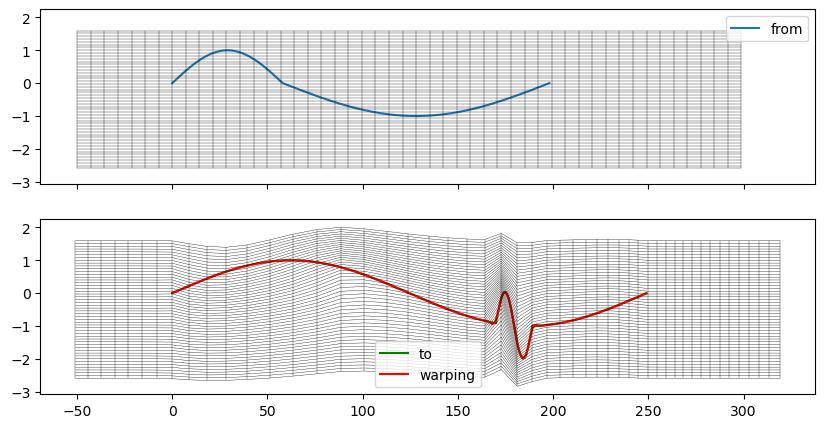

In [8]:
Kv = VFTSGaussianKernel(1,0.1,80,1,1)
Kl = TSGaussGaussKernel(2,1,1,1)

shoot = Shooting(Kv)
flow = Flowing(Kv)

p,q,qm= varifold_registration(s_emb[0],s_emb[1],t_emb[0],t_emb[1],Kv,Kl,niter=1000,optimizer=optax.adam(warmup_cosine_decay_schedule(0,0.05,40,400,0)),gamma_loss=0.01)
plot2Dfigure(s_emb[0],t_emb[0],p,shoot,flow,s_emb[1],t_emb[1])

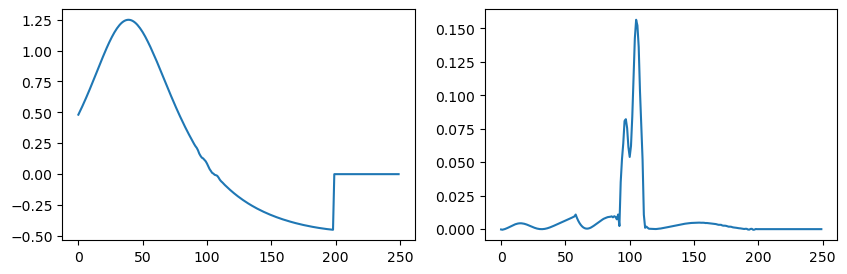

In [ ]:
dg = DeformationGradient(Kv)
gr = dg(p,s_emb[0],s_emb[1])

fig,axs = plt.subplots(1,2,figsize=(10,3))
axs[0].plot(gr[:,0,0])
axs[1].plot(gr[:,1,1])

In [ ]:
from src.masked.kernel import TSGaussKernel
from src.masked.lddmm import registration
from src.masked.loss import MMD,WeightedMMD

iteration:  1 / 1000  -- loss:  763.59
iteration:  10 / 1000  -- loss:  194.56
iteration:  20 / 1000  -- loss:  108.12
iteration:  30 / 1000  -- loss:  77.47
iteration:  40 / 1000  -- loss:  65.20
iteration:  50 / 1000  -- loss:  47.38
iteration:  60 / 1000  -- loss:  34.09
iteration:  70 / 1000  -- loss:  27.21
iteration:  80 / 1000  -- loss:  22.48
iteration:  90 / 1000  -- loss:  26.76
iteration:  100 / 1000  -- loss:  21.26
iteration:  110 / 1000  -- loss:  23.09
iteration:  120 / 1000  -- loss:  14.14
iteration:  130 / 1000  -- loss:  10.01
iteration:  140 / 1000  -- loss:  11.18
iteration:  150 / 1000  -- loss:  26.28
iteration:  160 / 1000  -- loss:  10.83
iteration:  170 / 1000  -- loss:  8.78
iteration:  180 / 1000  -- loss:  12.46
iteration:  190 / 1000  -- loss:  17.07
iteration:  200 / 1000  -- loss:  11.28
iteration:  210 / 1000  -- loss:  11.20
iteration:  220 / 1000  -- loss:  10.92
iteration:  230 / 1000  -- loss:  11.86
iteration:  240 / 1000  -- loss:  12.15
iteration

(<Figure size 1000x500 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

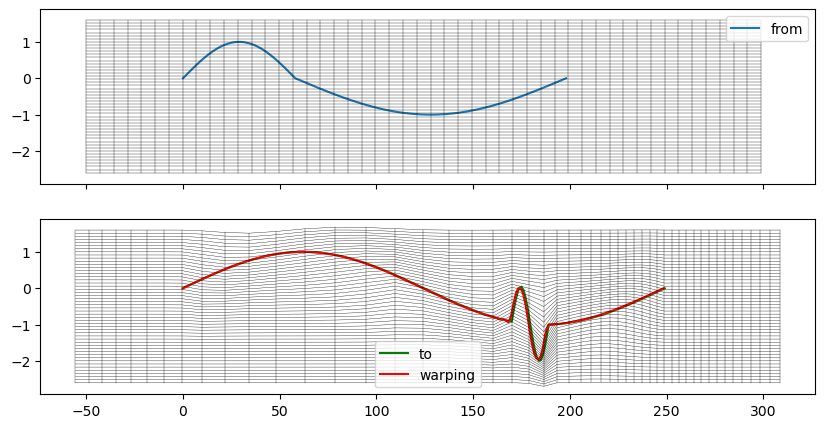

: 

In [ ]:
Kv = VFTSGaussKernel(5,0.1,80,1,1)
Kl = TSGaussKernel(2,1)
dataloss = WeightedMMD(Kl)

shoot = Shooting(Kv)
flow = Flowing(Kv)

p,q,qm= registration(s_emb[0],s_emb[1],t_emb[0],t_emb[1],Kv,dataloss,niter=1000,optimizer=optax.adam(learning_rate=0.05),gamma_loss=0.01)
plot2Dfigure(s_emb[0],t_emb[0],p,shoot,flow,s_emb[1],t_emb[1])

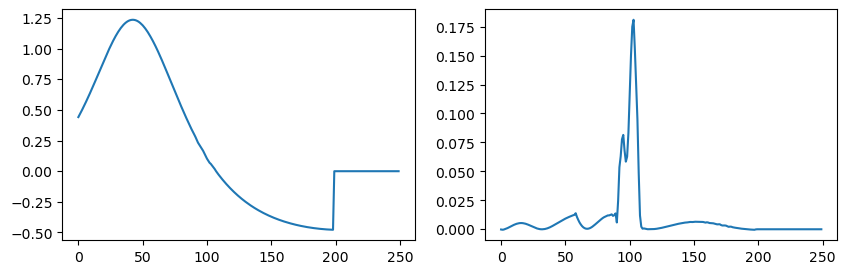

In [ ]:
dg = DeformationGradient(Kv)
gr = dg(p,s_emb[0],s_emb[1])

fig,axs = plt.subplots(1,2,figsize=(10,3))
axs[0].plot(gr[:,0,0])
axs[1].plot(gr[:,1,1])

## Barycenter

In [ ]:
from src.masked.barycenter import varifold_barycenter_registration

In [ ]:
np.random.seed(2)
lengths = np.random.randint(100,200,20)
sigs = [np.log(l)*np.sin(2*np.pi*np.linspace(0,1,l)).reshape(-1,1) for l in lengths]

X, masks = from_timeseries_to_dataset(sigs)

In [ ]:
ps ,qb, qb_mask= varifold_barycenter_registration(X,masks,Kv,Kl,niter=100)

In [ ]:
for sig in sigs: 
    plt.plot(sig,color="black",alpha=0.5)
plot_qb = qb[np.where(qb_mask==True)[0]]
plt.plot(*plot_qb.T,color="red")

In [ ]:
from src.statistic import MomentaPCA

In [ ]:
mpca = MomentaPCA(2,masked=True)

mpca.fit(Kv,ps,qb,qb_mask)

plt.scatter(*mpca.p_score_.T)

## Time

In [ ]:
from src.masked.lddmm import time_varifold_registration, TimeDeformationGradient,TimeFlowing,TimeShooting

In [ ]:
t_sig = np.sin(np.linspace(0,1,250)*2*np.pi)
t_sig[170:190] += 1*np.sin(np.linspace(0,1,20)*2*np.pi)
t_sig = t_sig.reshape(-1,1)
s_sig = np.vstack((np.sin(np.linspace(0,0.5,59)*2*np.pi).reshape(-1,1)[:-1],np.sin(np.linspace(0.5,1,141)*2*np.pi).reshape(-1,1)))
X,mask = from_timeseries_to_dataset([s_sig,t_sig])
s_emb,t_emb = list(zip(X,mask))

Kv = GaussKernel(100)
Kl = TSGaussGaussKernel(5,1,1,1)

shoot = TimeShooting(Kv)
flow = TimeFlowing(Kv)

p,q,qm= time_varifold_registration(s_emb[0],s_emb[1],t_emb[0],t_emb[1],Kv,Kl,niter=1000)
plot2Dfigure(s_emb[0],t_emb[0],p,shoot,flow,s_emb[1],t_emb[1])

In [ ]:
dg = TimeDeformationGradient(Kv)
gr = dg(p,s_emb[0],s_emb[1])

fig,axs = plt.subplots(1,1,figsize=(5,3))
axs.plot(gr[:,0])

## Shape

In [ ]:
from src.masked.lddmm import shape_varifold_registration,ShapeDeformationGradient,ShapeFlowing,ShapeShooting

In [ ]:
t_sig = np.sin(np.linspace(0,1,250)*2*np.pi)
t_sig[170:190] += 1*np.sin(np.linspace(0,1,20)*2*np.pi)
t_sig = t_sig.reshape(-1,1)
s_sig = np.vstack((np.sin(np.linspace(0,0.5,59)*2*np.pi).reshape(-1,1)[:-1],np.sin(np.linspace(0.5,1,141)*2*np.pi).reshape(-1,1)))
X,mask = from_timeseries_to_dataset([s_sig,t_sig])
s_emb,t_emb = list(zip(X,mask))

Kv = VFSGaussKernel(1.,1.)
Kl = TSGaussGaussKernel(5,1,1,1)

shoot = ShapeShooting(Kv)
flow = ShapeFlowing(Kv)

p,q,qm= shape_varifold_registration(s_emb[0],s_emb[1],t_emb[0],t_emb[1],Kv,Kl,niter=1000)
plot2Dfigure(s_emb[0],t_emb[0],p,shoot,flow,s_emb[1],t_emb[1])

In [ ]:
dg = ShapeDeformationGradient(Kv)
gr = dg(p,*s_emb)

fig,axs = plt.subplots(1,1,figsize=(5,3))
axs.plot(gr[:,0])

## Time Shape

In [ ]:
from src.masked.lddmm import time_shape_varifold_registration, TimeShapeDeformationGradient,TimeShapeShooting,TimeShapeFlowing

In [ ]:
t_sig = np.sin(np.linspace(0,1,250)*2*np.pi)
t_sig[170:190] += 1*np.sin(np.linspace(0,1,20)*2*np.pi)
t_sig = t_sig.reshape(-1,1)
s_sig = np.vstack((np.sin(np.linspace(0,0.5,59)*2*np.pi).reshape(-1,1)[:-1],np.sin(np.linspace(0.5,1,141)*2*np.pi).reshape(-1,1)))
X,mask = from_timeseries_to_dataset([s_sig,t_sig])
s_emb,t_emb = list(zip(X,mask))

t_Kv = GaussKernel(100)
t_Kl = TSGaussGaussKernel(5,1,1,1)

s_Kv = VFSGaussKernel(1.,1.)
s_Kl = TSGaussGaussKernel(5,1,1,1)

shoot = TimeShapeShooting(t_Kv,s_Kv)
flow = TimeShapeFlowing(t_Kv,s_Kv)

t_p,t_q,s_p,s_q,qm= time_shape_varifold_registration(s_emb[0],s_emb[1],t_emb[0],t_emb[1],t_Kv,t_Kl,s_Kv,s_Kl,t_niter=1000,s_niter=1000)
plot2Dfigure(s_emb[0],t_emb[0],t_p,shoot,flow,s_emb[1],t_emb[1],s_p)

In [ ]:
dg = TimeShapeDeformationGradient(t_Kv,s_Kv)
tgr,sgr = dg(t_p,s_p,*s_emb)

fig,axs = plt.subplots(1,2,figsize=(10,3))
axs[0].plot(tgr[:,0])
axs[1].plot(sgr[:,0])